# Transfer Learning Part 3: Scaling Up

We've seen the power of the transfer learning feature extraction and fine-tuning in the previous notebook, now it's time to scaling up to all classes Food101

Our goal is beat the original Food101 paper with %10 training data.
Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is %50.76 accuracy across 101 classes.

In [92]:
# Import necessary libraries
import os
import datetime
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import warnings
import itertools
from helper_functions import plot_loss_curves, compare_histories

warnings.filterwarnings('ignore')

print(tf.__version__)

2.12.0


## 101 Food Classes: Working with less data (%10 percent)

Let's download the %10 percent of Food101 data with all classes.

In [2]:
# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the data
zip_ref = zipfile.ZipFile('101_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-17 08:24:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.9MB/s    in 69s     

2023-07-17 08:25:29 (22.5 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [3]:
# Create the train and test dir
train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

In [4]:
# How many classes/images are there?
for dir in os.walk('101_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '101_food_classes_10_percent'
There are 101 directories and 0 images in '101_food_classes_10_percent/test'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_roll_sandwich'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/poutine'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/strawberry_shortcake'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/clam_chowder'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/shrimp_and_grits'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'
There are 0 directorie

In [5]:
# Setup data inputs
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print('Training data:')
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode='categorical',
                                                                                image_size=IMG_SIZE,
                                                                                batch_size=BATCH_SIZE)
print('\n')
print('Test data:')
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False) # dont shuffle test data for prediction analysis

Training data:
Found 7575 files belonging to 101 classes.


Test data:
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on %10 of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboed-model
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on %15 of the test data, to save epoch time)

In [6]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch',
                                                         monitor='val_accuracy')

In [7]:
# Create a data augmentation layer
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
], name='data_augmentation')

In [8]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = tf.keras.layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [10]:
# Summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
model_history = model.fit(train_data_all_10_percent,
                          epochs=5,
                          validation_data=test_data,
                          validation_steps=(0.15*len(test_data)), # %15 of test data
                          callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 115s 417ms/step - loss: 3.3724 - accuracy: 0.2693 - val_loss: 2.4200 - val_accuracy: 0.4814
Epoch 2/5
237/237 [==============================] - 76s 318ms/step - loss: 2.2107 - accuracy: 0.4952 - val_loss: 1.9753 - val_accuracy: 0.5334
Epoch 3/5
237/237 [==============================] - 67s 280ms/step - loss: 1.8324 - accuracy: 0.5681 - val_loss: 1.8297 - val_accuracy: 0.5467
Epoch 4/5
237/237 [==============================] - 61s 257ms/step - loss: 1.6361 - accuracy: 0.6026 - val_loss: 1.7804 - val_accuracy: 0.5454
Epoch 5/5
237/237 [==============================] - 56s 237ms/step - loss: 1.4618 - accuracy: 0.6429 - val_loss: 1.7354 - val_accuracy: 0.5512


In [13]:
# Evaluate the model with all test data
model.evaluate(test_data)

790/790 [==============================] - 59s 74ms/step - loss: 1.5901 - accuracy: 0.5809


[1.5900617837905884, 0.580910861492157]

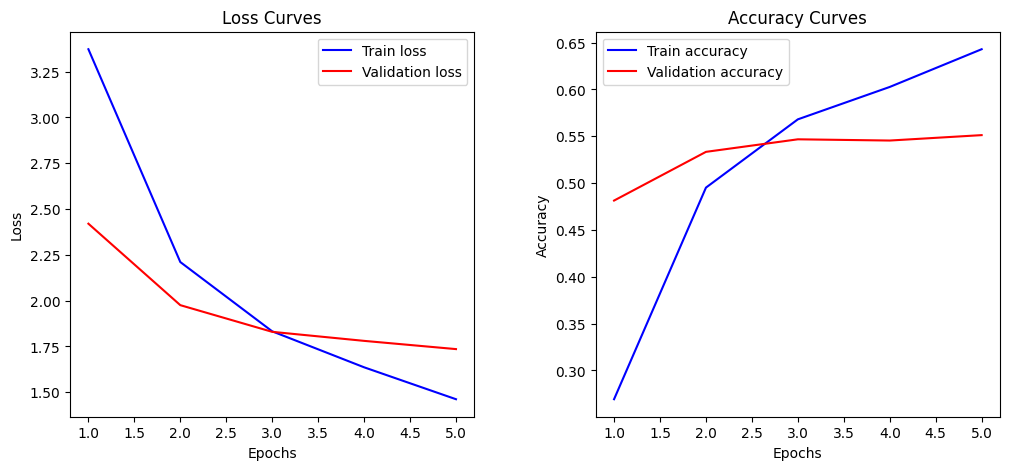

In [15]:
# Plot loss curves
plot_loss_curves(model_history)

Its look our model performed to well on train data and not generalizing to unseen data. (Overfitting)

## Fine-tuning

In [16]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [17]:
# Check out the layers
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [23]:
# Recompile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Set the fine tune epoch
fine_tune_epochs = len(model_history.epoch) + 5

# Fit the model
model_fine_tuning_history = model.fit(train_data_all_10_percent,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.15*len(test_data)),
                                      initial_epoch=model_history.epoch[-1],
                                      callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 58s 208ms/step - loss: 1.0616 - accuracy: 0.7188 - val_loss: 1.7396 - val_accuracy: 0.5450
Epoch 6/10
237/237 [==============================] - 48s 202ms/step - loss: 0.9970 - accuracy: 0.7327 - val_loss: 1.7033 - val_accuracy: 0.5559
Epoch 7/10
237/237 [==============================] - 46s 193ms/step - loss: 0.9445 - accuracy: 0.7432 - val_loss: 1.7045 - val_accuracy: 0.5508
Epoch 8/10
237/237 [==============================] - 43s 178ms/step - loss: 0.8893 - accuracy: 0.7593 - val_loss: 1.6891 - val_accuracy: 0.5524
Epoch 9/10
237/237 [==============================] - 44s 185ms/step - loss: 0.8476 - accuracy: 0.7752 - val_loss: 1.6980 - val_accuracy: 0.5553
Epoch 10/10
237/237 [==============================] - 43s 180ms/step - loss: 0.7762 - accuracy: 0.7951 - val_loss: 1.7102 - val_accuracy: 0.5514


In [26]:
# Evaluate on the whole test data
model.evaluate(test_data)

790/790 [==============================] - 66s 83ms/step - loss: 1.4917 - accuracy: 0.6043


[1.491723656654358, 0.6043168306350708]

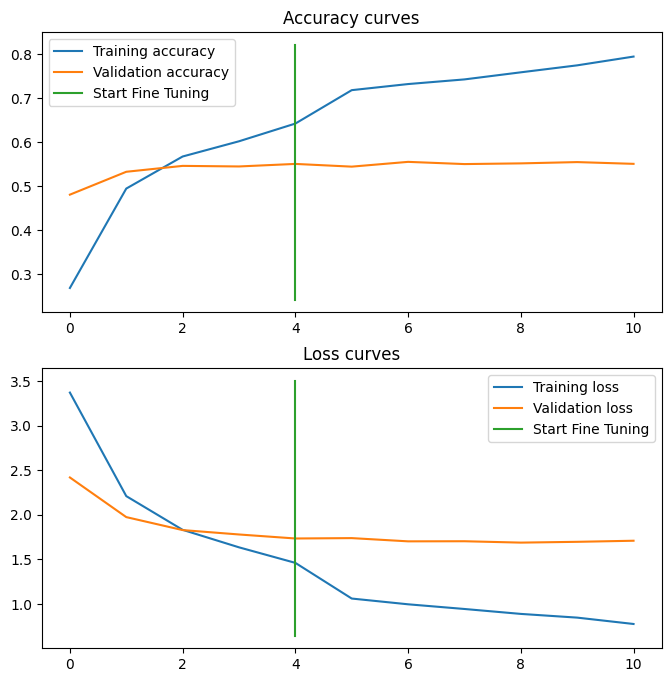

In [25]:
# Compare the histories of feature extraction model and fine tuned model
compare_histories(model_history, model_fine_tuning_history)

Training loss and accuracy is performed well but validation metrics is not so its obvious this is overfitting.

## Make predictions with our trained model

Let's make some predictions, visualize them and then later find out which predictions were the 'most' wrong.

In [42]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
790/790 [==============================] - 81s 101ms/step


In [44]:
# How many predictions are there?
len(preds_probs)

25250

In [46]:
# What the shapes of our predictions?
preds_probs.shape

(25250, 101)

In [47]:
# Let's see what the first 10 predictions look like?
preds_probs[:10]

array([[3.47320497e-01, 7.19696909e-05, 1.49397418e-01, ...,
        9.35224671e-06, 8.76004808e-03, 1.01288594e-02],
       [9.30709958e-01, 1.20612915e-08, 7.55669549e-04, ...,
        1.46563642e-03, 4.64695873e-08, 9.22676463e-07],
       [6.05839372e-01, 1.96015220e-02, 8.02322011e-03, ...,
        1.82621647e-04, 7.41838652e-04, 2.59102019e-03],
       ...,
       [2.14224011e-01, 8.43582438e-06, 1.78525026e-03, ...,
        2.61538327e-02, 2.53027305e-04, 1.25130566e-04],
       [9.88639146e-02, 5.59377309e-04, 4.69163835e-01, ...,
        1.82452539e-04, 2.65865412e-04, 1.45991624e-04],
       [6.75764978e-01, 5.17324565e-07, 4.10321122e-03, ...,
        1.69336901e-03, 1.27393764e-06, 6.08959759e-04]], dtype=float32)

In [52]:
# Let's see the first predictions
preds_probs[0], len(preds_probs[0])

(array([3.47320497e-01, 7.19696909e-05, 1.49397418e-01, 5.03817546e-07,
        4.70567420e-06, 6.02534158e-07, 4.05424144e-05, 9.23614834e-07,
        3.06847058e-02, 1.10761197e-04, 3.82383092e-07, 8.16822921e-06,
        2.19256253e-04, 9.13240541e-08, 9.57855547e-04, 1.03019783e-03,
        6.66673986e-06, 3.17614991e-04, 9.80429817e-03, 1.36223462e-05,
        1.21353415e-03, 6.75758474e-06, 1.03371225e-04, 1.22081634e-04,
        2.61730445e-03, 8.40374152e-04, 6.81841339e-04, 3.04550613e-05,
        5.94011135e-02, 1.42412516e-03, 2.62401227e-06, 2.53770268e-03,
        8.07726814e-04, 4.92775939e-07, 1.84487794e-02, 4.49810568e-06,
        2.88442807e-05, 1.02753879e-03, 2.03449503e-02, 2.92450277e-05,
        1.70417901e-04, 2.46992381e-03, 1.23387872e-04, 9.56582007e-05,
        7.06607752e-05, 6.60114965e-05, 1.45534833e-03, 8.50115539e-05,
        6.28487328e-07, 1.24088019e-01, 6.78845026e-05, 1.39491152e-04,
        5.58859557e-02, 5.06491326e-02, 7.42294797e-05, 5.488447

In [57]:
# We get one prediction probability per class (in our case there are 101 prediction probabilities)
print(f'Number of prediction probabilities for sample 0: {len(preds_probs[0])}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}')

Number of prediction probabilities for sample 0: 101
The class with the highest predicted probability by the model for sample 0: 0


In [59]:
# Get tge ored classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29, 46,  2,  0])

In [60]:
# How many pred classes we have?
len(pred_classes)

25250

Now, we got the prediction arrays of all of model's predictions, to evaluate them, we need to compare them to the orihjinal test dataset labels.

In [65]:
tf.data.experimental.unbatch()

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.


<function tensorflow.python.data.experimental.ops.batching.unbatch.<locals>._apply_fn(dataset)>

In [73]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

y_labels[:10] # look at the first 10 label

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [74]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating models predictions

One way to check our model predictions array is in the same order as our test labels arrays is to find the accuracy score.

In [76]:
# Remind the model accuracy
model_result = model.evaluate(test_data)
model_result

790/790 [==============================] - 65s 82ms/step - loss: 1.4917 - accuracy: 0.6043


[1.491723656654358, 0.6043168306350708]

In [86]:
# Let's try scikit-learn's accuracy score funtion and see what it comes up
from sklearn.metrics import accuracy_score, confusion_matrix
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6043168316831683

Got the same results! Well.

## Let's get visual: making a confusion matrix

In [96]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [97]:
# Make a confusion matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=10)

## Let's keep the evaluation train going, time for a classification report
Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and f1) called classification report.

In [98]:
# Import classification report from sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.25      0.28       250
           1       0.51      0.76      0.61       250
           2       0.59      0.60      0.60       250
           3       0.81      0.54      0.65       250
           4       0.56      0.36      0.43       250
           5       0.49      0.36      0.42       250
           6       0.77      0.73      0.75       250
           7       0.85      0.76      0.80       250
           8       0.32      0.54      0.40       250
           9       0.51      0.58      0.54       250
          10       0.53      0.44      0.48       250
          11       0.70      0.66      0.68       250
          12       0.70      0.62      0.66       250
          13       0.52      0.60      0.56       250
          14       0.69      0.49      0.57       250
          15       0.47      0.34      0.40       250
          16       0.67      0.59      0.63       250
          17       0.38    